# Constrained feature matching.

After achieving a lot of matches, we want to filter them based on geometric constraints.\
The F matrix constraints points to a line, so we will use our matches to RANSAC estimate F, \
and then remove outlayer matches after finding our best F from RANSAC.

## The Eight Point Algorithm
Here you will write a function that uses the eight point algorithm for fundamental matrix estimation. \
This should be a slight modification of your algorithm for homography estimation. As for the homography \
estimation the data points should also be normalized. Find the fundamental matrix that you computed for \
the images in TwoImageData.npy in week 3 and denote it Ftrue.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

In [2]:
def fundamental(R, t, K1, K2):
    """
    The R and t relates the two cameras.
    K1 and K2 for each camera.
    Returns the F which relates the camera on the pixel plane.
    """
    E = crossOp(t)@R

    return (np.linalg.inv(K2)).T @ E @ (np.linalg.inv(K1))
    
def crossOp(p):
    """
    returns is a 3x3 matrix, corresponding to taking crossproduct of p.
    [p]_x = CrossOp(p)
    """
    return np.array([
        [0, -p[2], p[1]],
        [p[2], 0, -p[0]],
        [-p[1], p[0], 0]], dtype=type(p[0][0]))
        
qs = np.load('week09_data/qs.npy', allow_pickle=True).item()
two_image_data = np.load('TwoImageData.npy', allow_pickle=True).item()

In [3]:
######################################
gray_left = two_image_data["im1"]
gray_right = two_image_data["im2"]
R1 = two_image_data["R1"]
R2 = two_image_data["R2"]
t1 = two_image_data["t1"]
t2 = two_image_data["t2"]
K1 = two_image_data["K"]
K2 = K1.copy()
######################################
Rtilde = R2@R1.T # Relative rotation
ttilde = t2 - R2@R1.T@t1 # Relative translation
Ftrue = fundamental(Rtilde, ttilde, K1, K2)
#####################################
q1 = qs["q1"]
q2 = qs["q2"]
Ftrue

array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

### 9.1 SVD F approximator

Implement a function Fest_8point that estimates a fundamental matrix from eight (or more point) \
correspondences, using the linear algorithm. Use the points in qs.npy to estimate a fundamental \
 matrix, and check that your estimated fundamental matrix is identical to Ftrue up to scale and numerical error


First, a quick look at normalization: 

1. From homography we had: Hq2 = q1, so H' (T2@q2) = T1@q1 => H = T1.inv @ H' @ T2
2. Now we have: q2.T@F@q1 = 0, so (T2@q2).T @ F' @ (T1@q1) = 0 => F = T2.T @ F' @ T1

Text(0.5, 1.0, 'Normed points')

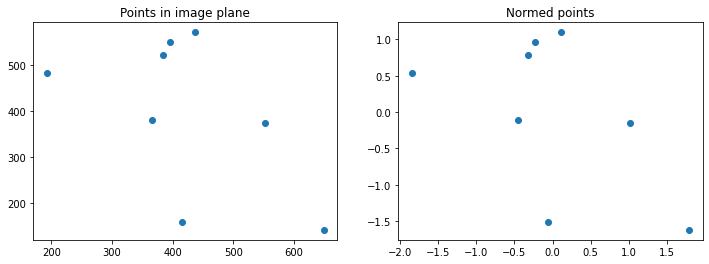

In [4]:
###################
## Normalization ##
###################
mean = np.mean(q1,axis=1)
std = np.std(q1,axis=1)
T = np.array([[1/std[0],0,-mean[0]/std[0]],
                [0,1/std[1],-mean[1]/std[1]],
                [0,0,1]])
                
normed_q1 = T@q1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].scatter(q1[0,:], q1[1, :])
ax[0].set_title("Points in image plane")
ax[1].scatter(normed_q1[0,:], normed_q1[1, :])
ax[1].set_title("Normed points")

In [5]:
def normalize2d(Q):
    mean = np.mean(Q,axis=1)
    std = np.std(Q,axis=1)
    T = np.array([[1/std[0],0,-mean[0]/std[0]],
                  [0,1/std[1],-mean[1]/std[1]],
                 [0,0,1]])
    return [T@Q, T]

def get_B(q1,q2):
    B = np.array([q1[0, 0]*q2[0, 0], q1[0, 0]*q2[1, 0], q1[0, 0],
                  q1[1, 0]*q2[0, 0], q1[1, 0]*q2[1, 0], q1[1, 0],
                  q2[0, 0], q2[1, 0], 1])
    for i in range(1,len(q1[0])):
        B_new_row = np.array([q1[0, i]*q2[0, i], q1[0, i]*q2[1, i], q1[0, i],
                              q1[1, i]*q2[0, i], q1[1, i]*q2[1, i], q1[1, i],
                              q2[0, i], q2[1, i], 1])
        B = np.vstack((B,B_new_row))
    return B

def Fest_8point(q1, q2, normalize=True):
    # Normalize the points
    if normalize:
        q1,T1 = normalize2d(q1)
        q2,T2 = normalize2d(q2)
    # Construct the B matrix from the matching points
    B = get_B(q1, q2)
    # Run the SVD algorithm: 0 = B@Flatten(F.T)
    _,_,VT = np.linalg.svd(B.T@B) #U,S,VT = np.linalg.svd(np.hstack((B.T,B)))
    # VT is sorted in descending order of singular value
    F_vec = VT[-1]
    F = np.array([[F_vec[0], F_vec[3], F_vec[6]],
                  [F_vec[1], F_vec[4], F_vec[7]],
                  [F_vec[2], F_vec[5], F_vec[8]]])
    if normalize:
        #return (np.linalg.inv(T1)@F.T@T2.round(2))
        return T2.T@F@T1
    else:
        return F

In [6]:
Fest = Fest_8point(q1, q2, normalize=True)
Fest = Fest/Fest[0, 0] * Ftrue[0, 0]
Ftrue

array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

In [7]:
Ftrue

array([[ 6.67972386e-12, -7.85049967e-10,  1.17921973e-07],
       [-9.75936980e-10, -4.86806510e-12,  3.28699196e-05],
       [ 4.23506610e-07, -3.21704080e-05, -2.12002228e-04]])

## Feature matching

### 9.2 Make SIFT matches 
Repeat part of the exercise from last week, by matching the two images from TwoImageData.npy. \
However, this time do not filter matches by the ratio test, only use cross checking as done by \
cv2.BFMatcher_create(crossCheck=True). Visualize the result and confirm that it looks reasonable \
compared to your expectations.


```Java
CrossCheck which is false by default. If it is true, Matcher returns only those matches with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match and vice-versa. That is, the two features in both sets should match each other. It provides consistant result, and is a good alternative to ratio test proposed by D.Lowe in SIFT paper.
```

In [8]:
# Use SIFT to getkeypoints and their descriptors
sift = cv2.xfeatures2d.SIFT_create(#nfeatures = 1000, # no.best features to retain
                                   nOctaveLayers = 5, # Octave layer in DoG - automatically computed
                                   contrastThreshold = 0.04, #Filter out weak features in semi-uniform regions. The larger the threshold, the less features are produced by the detector.
                                   edgeThreshold = 10000, # Filter out edge-like features. The larger this Threshold, the less features are filtered out. 
                                   sigma = 1.6 ) # Sigma of the gaussian at octave 0
                                   
kp1, des1 = sift.detectAndCompute(gray_left, None) #Keypoints and descriptors
kp2, des2 = sift.detectAndCompute(gray_right, None) #Keypoints and descriptors

In [9]:
# Match using brute force matcher, with crossCheck.
bf = cv2.BFMatcher_create(crossCheck=True)
matches = bf.match(des1, des2)
len(matches)

4024

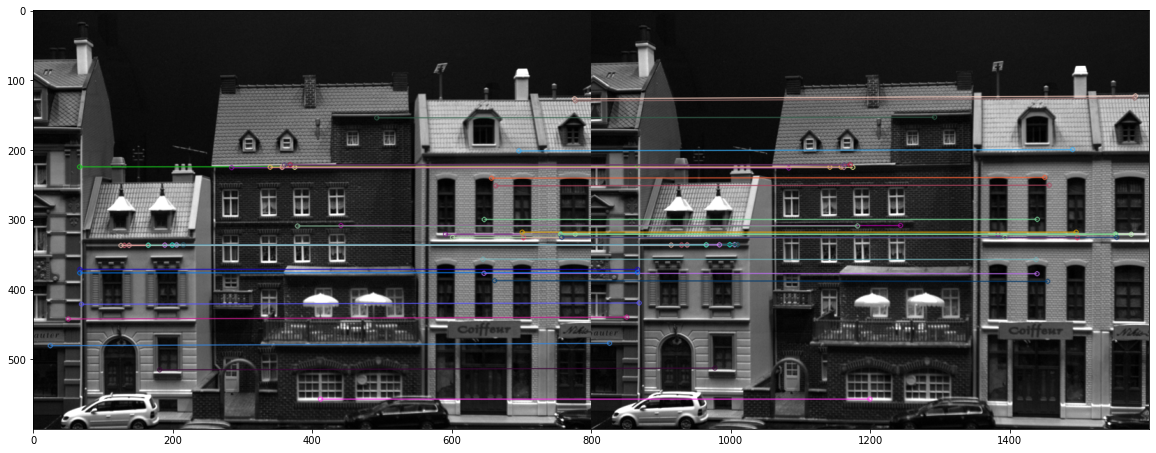

In [10]:
# We can sort the matches, to get the closest matches first
sorted_matches = sorted(matches, key = lambda x:x.distance)
# We then draw our matches onto one image
match_img = cv2.drawMatches(gray_left,kp1,gray_right,kp2,sorted_matches[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(match_img)

In [11]:
match = matches[15]

## Fundamental matrix estimation via RANSAC
Make a copy of your RANSAC algorithm that fits straight lines, and modify it to fit fundamental
matrices instead.

### 9.3 RANSAC
Sample eight random matches. This can be done with the following code ```np.random.choice(matches, 8, replace=False).``` \
Use your function Fest_8point to estimate the fundamental matrix from these eight matches. Write a function ```SampsonsDistance(F, p1, p2)``` \
that computes Sampson’s distance. Set points to inliers if their Sampson’s distance is less than 3.84 · 3ˆ2. Explain where this value \
comes from. Use your ```Fest_8point``` to estimate the final fundamental matrix using all inliers of the best model. \
Run your algorithm on the the images from TwoImageData.npy. Compare your estimated F to Ftrue. 

You could use the following code to compare them:\
```(F*Ftrue).sum() / (np.linalg.norm(F)*np.linalg.norm(Ftrue))```\
Explain what this code does.

In [12]:
def SampsonsDistance(F, p1, p2):
    """
    params:
        - p1, p2 is 3x1 homogenous matching points
        - F is a 3x3 proposed fundamental matrix

    return: sampson distance between points
    """
    a1 = (p2.T@F)[0]**2
    b1 = (p2.T@F)[1]**2
    a2 = (F@p1)[0]**2
    b2 = (F@p1)[1]**2

    return (p2.T@F@p1)**2 * 1/(a1 + b1 + a2 + b2)

In [13]:
print("Two matching points:", SampsonsDistance(Ftrue, q1[:, 0], q2[:, 0]), "(~ 0)")
print("Two non-matching points:", SampsonsDistance(Ftrue, q1[:, 1], q2[:, 0]))


Two matching points: 1.428214067015515e-27 (~ 0)
Two non-matching points: 799.8855931222665


In [14]:
def SIFT_extractor(gray_left, gray_right):
    # Use SIFT to getkeypoints and their descriptors
    sift = cv2.xfeatures2d.SIFT_create(#nfeatures = 1000, # no.best features to retain
                                    nOctaveLayers = 5, # Octave layer in DoG - automatically computed
                                    contrastThreshold = 0.04, #Filter out weak features in semi-uniform regions. The larger the threshold, the less features are produced by the detector.
                                    edgeThreshold = 10000, # Filter out edge-like features. The larger this Threshold, the less features are filtered out. 
                                    sigma = 1.6 ) # Sigma of the gaussian at octave 0
                                    
    kp1, des1 = sift.detectAndCompute(gray_left, None) #Keypoints and descriptors
    kp2, des2 = sift.detectAndCompute(gray_right, None) #Keypoints and descriptors

    # Match using brute force matcher, with crossCheck.
    bf = cv2.BFMatcher_create(crossCheck=True)
    matches = bf.match(des1, des2)

    p1s, p2s = [], []
    for match in matches:
        p1s.append(kp1[match.queryIdx].pt)
        p2s.append(kp2[match.trainIdx].pt)

    return matches, np.asarray(p1s).T, np.asarray(p2s).T, kp1, kp2

In [15]:
def consensus(Fest, q1, q2, sigma):
    threshold = 3.84*sigma**2
    inliers_index = []
    for i in range(len(q1[0])):
        sdist = SampsonsDistance(Fest, q1[:, i], q2[:, i])
        if sdist<threshold:
            inliers_index.append(i)
    return len(inliers_index), np.asarray(inliers_index)

In [16]:
def RANSAC_8_point(p1s, p2s, sigma=3, iterations=500):

    # RANSAC iterations
    best_inliers = 0
    Fbest = None
    for i in range(iterations):
        # Draw eight random matches
        match_idx = np.random.randint(low=0, high=len(p1s[0]), size=(8,))
        q1 = p1s[:, match_idx]
        q2 = p2s[:, match_idx]
        # Estimate the line
        Fest = Fest_8point(q1, q2, normalize=True)
        # Find no. inliers
        no_inliers, _ = consensus(Fest, p1s, p2s, sigma)
        if no_inliers>best_inliers:
            Fbest = Fest
            best_inliers = no_inliers
            print(i, "New best estimate!")

    # Now, use all inliers of best F to match a final F
    _, inlier_index = consensus(Fbest, p1s, p2s, sigma)
    Final_F = Fest_8point(p1s[:, inlier_index], p2s[:, inlier_index], normalize=True)
    return Final_F, inlier_index

In [17]:
# Get all matches and points corresponding to matches
matches, p1s, p2s, _, _ = SIFT_extractor(gray_left, gray_right)
p1s = np.vstack((p1s, np.ones(len(p1s[0]))))
p2s = np.vstack((p2s, np.ones(len(p2s[0]))))

ransac_F, _ = RANSAC_8_point(p1s, p2s, sigma=3, iterations=1000)
ransac_F = ransac_F/ransac_F[0, 0] * Ftrue[0, 0]

0 New best estimate!
4 New best estimate!
5 New best estimate!
6 New best estimate!
14 New best estimate!
15 New best estimate!
39 New best estimate!
113 New best estimate!
126 New best estimate!


In [18]:
print("----------------------Final F----------------------")
print(ransac_F)
print("----------------------True F----------------------")
print(Ftrue)
print("\n\n\n----------------------Distances--------------------")
print("True->Ransac:", np.linalg.norm(Ftrue-ransac_F))


----------------------Final F----------------------
[[ 6.67972386e-12 -4.75847570e-08  1.19946043e-05]
 [ 1.50295116e-08 -1.12011493e-09  5.83580326e-04]
 [-1.89376522e-06 -5.70286060e-04 -3.92310736e-03]]
----------------------True F----------------------
[[ 6.67972386e-12 -7.85049967e-10  1.17921973e-07]
 [-9.75936980e-10 -4.86806510e-12  3.28699196e-05]
 [ 4.23506610e-07 -3.21704080e-05 -2.12002228e-04]]



----------------------Distances--------------------
True->Ransac: 0.0037901580631138927


### 9.4 Self captured images

Find the images you captured last week or capture new ones. Match SIFT features between these \
images using cross checking. Estimate the fundamental matrix between these images using your RANSAC \
algorithm. Comment on how well the fundamental matrix acts as a regularizer on which matches are used.

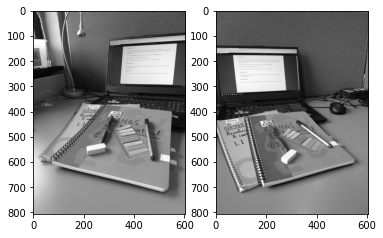

In [19]:
# Load image
left_color = cv2.imread('week08_data/image_from_left.jpg')
left = cv2.cvtColor(left_color, cv2.COLOR_RGB2GRAY)
right_color = cv2.imread('week08_data/image_from_right.jpg')
right = cv2.cvtColor(right_color, cv2.COLOR_RGB2GRAY)

# Need to scale down images for better visualization
scale_percent = 20 # percent of original size
width = int(right.shape[1] * scale_percent / 100)
height = int(right.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
right = cv2.resize(right, dim, interpolation = cv2.INTER_AREA)
left = cv2.resize(left, dim, interpolation = cv2.INTER_AREA)

# Show
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(right, cmap="gray")
ax[1].imshow(left, cmap="gray");

In [20]:
# Get all matches and points corresponding to matches
matches, p1s, p2s, kp1, kp2 = SIFT_extractor(right, left)
p1s = np.vstack((p1s, np.ones(len(p1s[0]))))
p2s = np.vstack((p2s, np.ones(len(p2s[0]))))

ransac_F, inlier_index = RANSAC_8_point(p1s, p2s, sigma=3, iterations=1000)

0 New best estimate!
2 New best estimate!
14 New best estimate!
22 New best estimate!
33 New best estimate!
42 New best estimate!
47 New best estimate!
83 New best estimate!
210 New best estimate!
222 New best estimate!


In [21]:
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

inMatches = np.array([matches])[0, inlier_index][:]
inMatches = totuple(inMatches)

print(len(matches), len(inMatches))

585 155


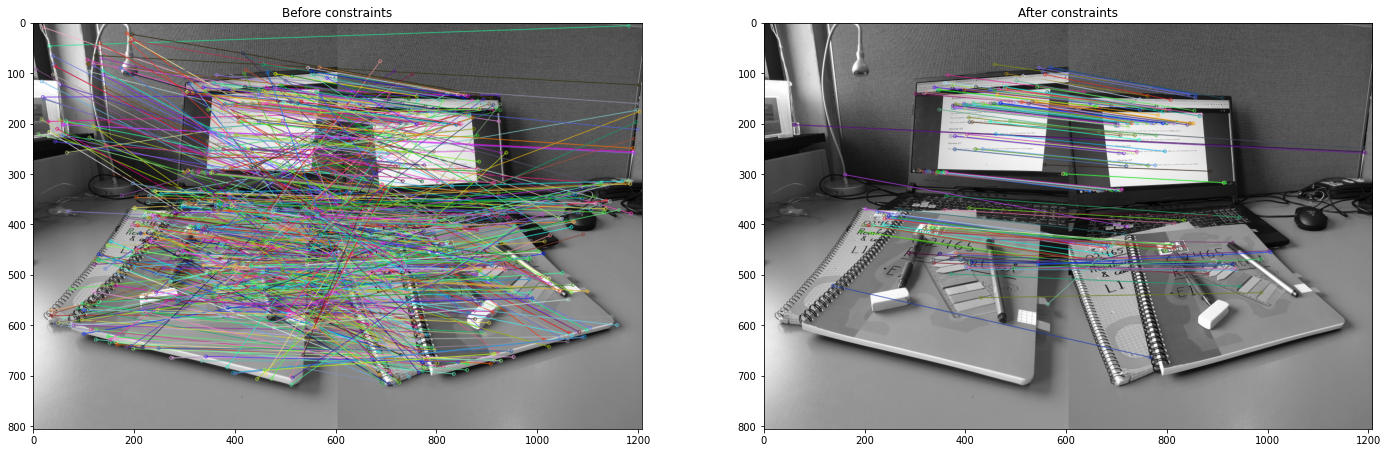

In [22]:
match_frame_before = cv2.drawMatches(right,kp1,left,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
match_frame_after = cv2.drawMatches(right,kp1,left,kp2,inMatches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (24, 12))
axs[0].set_title("Before constraints")
axs[1].set_title("After constraints")
axs[0].imshow(match_frame_before)
axs[1].imshow(match_frame_after);

**WOW!** Look how the fundamental matrix constraint locks all matches withing epipolar lines! That is cool. 

The F is powerful and gave good results, but was slower than say the ratio test. 